##**Image-Sharpening ConvNet**

We are going to work with high-res images of a bunch of manga comicbook covers. Word of warning: high-res images means tons of pixels, which means tons of data in memory and big tensor operations.

# Import Dataset

In [2]:
import pandas as pd
from google.colab import files
import io

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The shape of each image is (584, 416, 3).


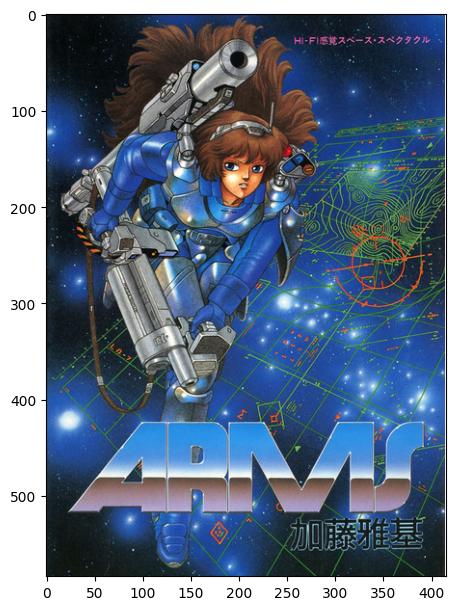

In [3]:
import numpy as np
import glob
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image_list = []
for file in glob.glob("/content/drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 5-6/manga_low/*"):
    im=Image.open(file)
    # I am stripping off the last row.
    img_array = np.array(im)[:-1,:,:]
    # Then I am adding two columns of white pixels. Why
    white = np.ones(shape=(584,2,3))*255
    img_array = np.hstack([img_array,white])
    img_array = np.divide(img_array,255)
    image_list.append(img_array)

dpi = 80

height, width, depth = image_list[0].shape
figsize = width / float(dpi), height / float(dpi)

print(f'The shape of each image is {image_list[0].shape}.')

plt.figure(figsize=figsize)
plt.imshow(image_list[0])
plt.show()

#*Optional: Dataset Augmentation.*

With image data, it's pretty straight forward for us to synthesize new training examples by copying and then randomly manipulating the images we've already got!

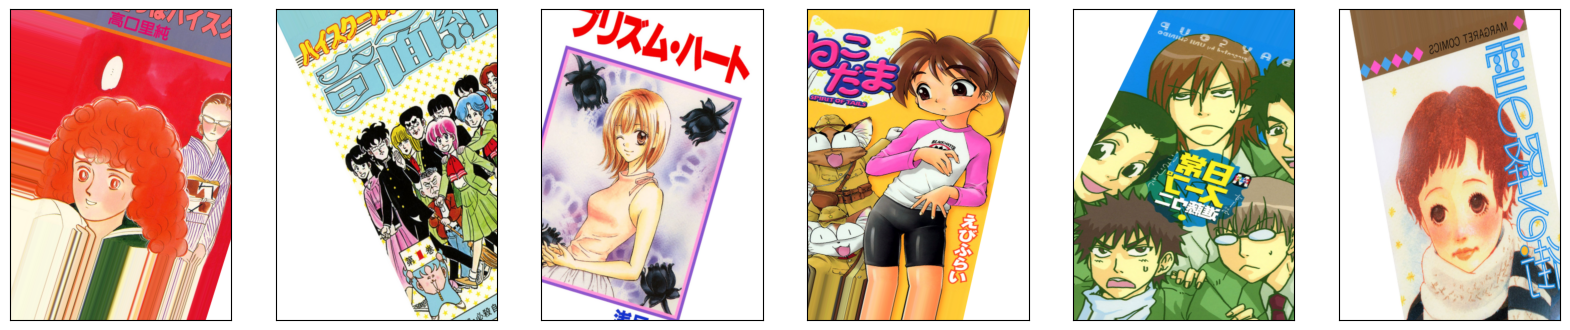

We now have a total of 304 images.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# First, 'train' the image data generator on our sample.
datagen.fit(image_list)

# Now we create the iterator... we can keep pulling new randomly transformed pictures out of this forever.
image_batches = datagen.flow(np.stack(image_list,axis=0), batch_size=30)

n = 5
plt.figure(figsize= (20,10))

q = 0
for i,batch in enumerate(image_batches):
    for j, image in enumerate(batch):
        if j == 1:
            # Only plot the first 6 photos.
            if i <= 5:
                ax = plt.subplot(1, 6, i+1)
                plt.imshow(tf.keras.utils.array_to_img(image))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

        # The iterator outputs image data with pixel values between 0-1; we are using values between 0-255 elsewhere.
        # We need to make the pixel values align.
        image_list.append(np.multiply(image,255))

    # Telling the script to stop asking for new images after several batches.
    if q > 5:
      break

    q += 1

plt.show()

print(f'We now have a total of {len(image_list)} images.')

Lastly, let's make our X's now; the pixellated versions of the high resolution images.

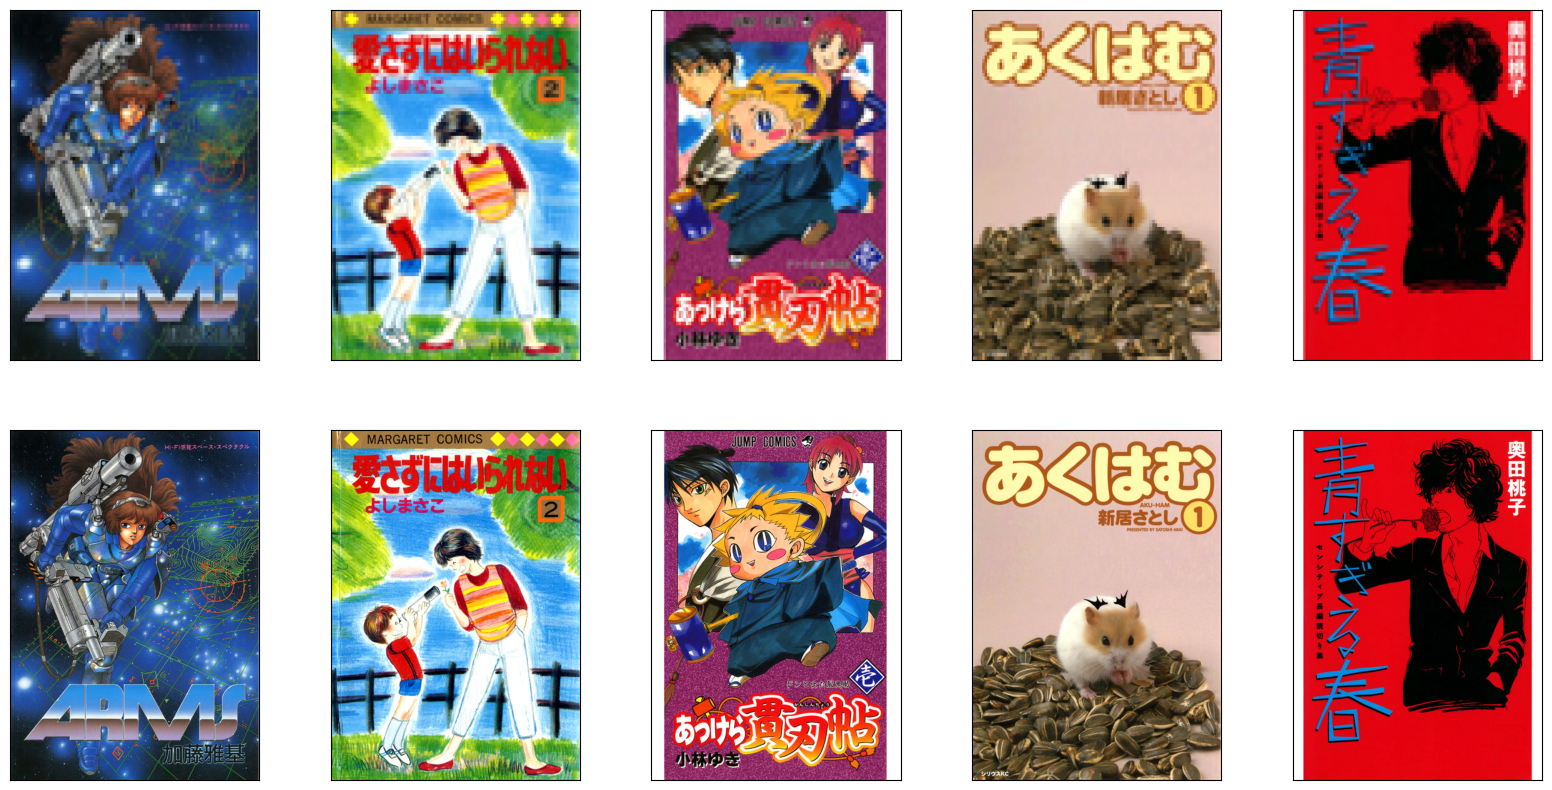

In [5]:
import tensorflow as tf
import numpy as np

pixelated_list = []

# This part determines how difficult the problem is.
# If we downsample too much, there's not enough signal left in the data to recover the original.
# Try this with downsampling to 100x100 or even lower. The model won't be able to solve the problem.
for image in image_list:
  image = Image.fromarray(np.multiply(image,255).astype('uint8'))

  # Next, make the pixelated version of the original image.
  image_tiny = image.resize((100,100))    # resize it to a tiny size
  pixelated = image_tiny.resize(image.size,Image.NEAREST)   # scale it back up

  # Store the pixelated photo.
  pixelated = tf.keras.utils.img_to_array(pixelated)
  pixelated_list.append(pixelated)

# We will put these into NumPy arrays for use in our NN later.
pixelated_array = np.stack(pixelated_list, axis=0)
image_array = np.stack(image_list, axis=0)

# Let's plot the first 5 pairs of training images and their labels (in RGB).
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(tf.keras.utils.array_to_img(pixelated_list[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# Create Our Neural Network

Now, we just need to create a model that takes the pixelated image as input, and tries to predict the original.

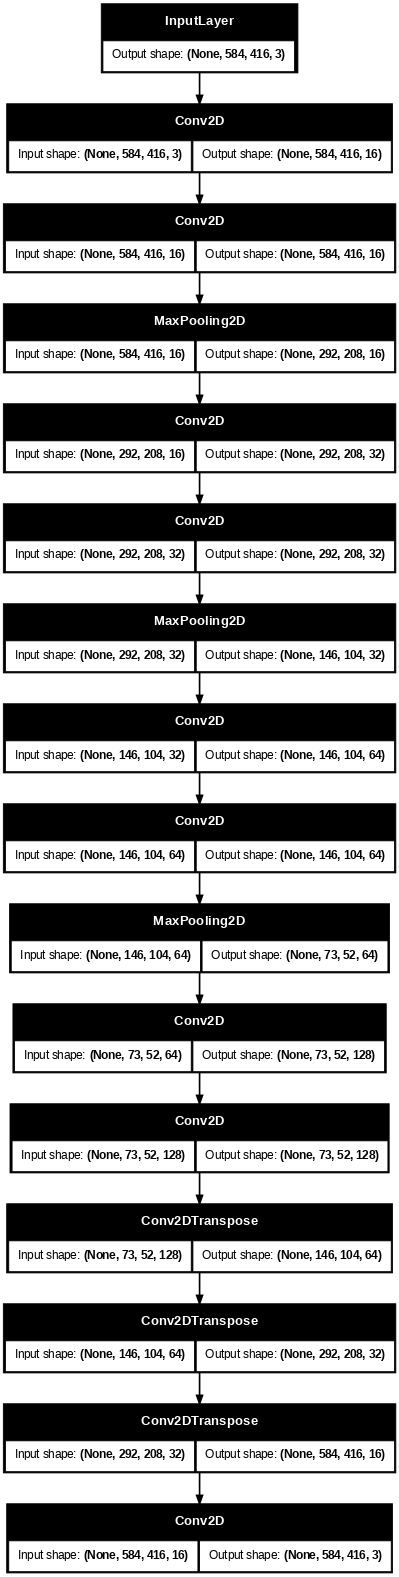

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from keras import backend as K

# These are both custom loss functions we can define that are appropriate for measuring differences between to pictures.
# Note, higher PSNR is desirable, so we multiple by -1 so that minimizing this value makes our model better.
def psnrLoss(y_true, y_pred, max_pixel=255.0):
    psnr = tf.image.psnr(y_true,y_pred,max_val=max_pixel)
    return -1*psnr

inputs = keras.Input(shape=(height, width, 3))

# Encoder portion...
x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2), padding="same")(x)
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2), padding="same")(x)
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2), padding="same")(x)
x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
encoding = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

# Decoder portion
x = layers.Conv2DTranspose(64, (3,3), strides=2,activation="relu", padding="same")(encoding)
x = layers.Conv2DTranspose(32, (3,3), strides=2,activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3,3), strides=2, activation="relu", padding="same")(x)
outputs = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

model = keras.Model(inputs, outputs)

# Compile the model - note, PSNR is positive signal to noise ratio (a loss metric that is specific to assessing image quality)
model.compile(optimizer="adam", loss=psnrLoss, metrics=['mse'])

keras.utils.plot_model(model, show_shapes=True, dpi=60)


Okay, let's try fitting this model...

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint("superResolution.keras",
                                    save_best_only=True)
]

history = model.fit(pixelated_array,image_array,batch_size=16, epochs=100, validation_split=0.2,callbacks=callbacks)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - loss: -58.1075 - mse: 0.1062 - val_loss: -60.9182 - val_mse: 0.0560
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: -60.0518 - mse: 0.0690 - val_loss: -61.4165 - val_mse: 0.0506
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: -60.6665 - mse: 0.0612 - val_loss: -61.7432 - val_mse: 0.0476
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: -60.9700 - mse: 0.0582 - val_loss: -62.3489 - val_mse: 0.0416
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: -61.6195 - mse: 0.0500 - val_loss: -62.5804 - val_mse: 0.0388
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: -61.8614 - mse: 0.0458 - val_loss: -62.8906 - val_mse: 0.0359
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: -63.1161 - mse: 0.0344 - val_loss: -63.9063 - val_mse: 0.0281
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: -63.4202 - mse: 0.0315 - val_loss: -64.8526 - val_mse: 0.0225
Epoch 9/100
16/

And, let's plot the loss over epochs...

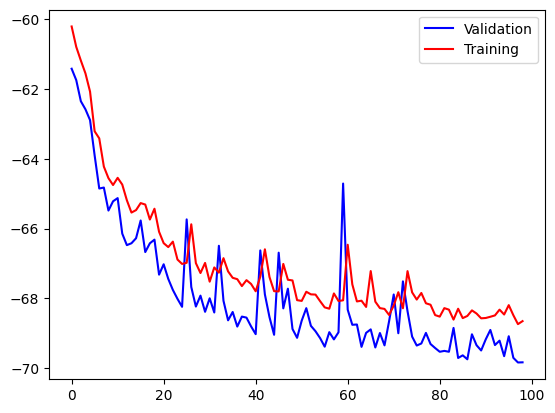

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'][1:],c="b")
plt.plot(history.history['loss'][1:],c="r")
plt.legend(['Validation','Training'])
plt.show()

Let's spit out some of the predictions from this model to see how well it works...

In [13]:
custom_objects = {'psnrLoss': psnrLoss}

model = keras.models.load_model("superResolution.keras",custom_objects=custom_objects)
sharpened_array = model.predict(pixelated_array[:15])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Our sharpener works, though it has some trouble with white pixels (it fills in some black pixels). It may need more white examples to figure those out well.

In [ ]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow((pixelated_array[i]).astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow((sharpened_array[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()